# Exploration of Imbalanced Banking Dataset Using Machine Learning

### Tucker Laurence, Ryan Worley

This notebook is a comprehensive report detailing the approaches and results of our CS345 project.

The dataset explored in this project contains data from direct marketing campaigns by a Portuguese bank, conducted through phone calls. The purpose of the calls was to determine whether the client answered “yes” or “no” to a bank term deposit subscription. Often, multiple contacts with the same client were necessary.

The data includes features relating to client information, such as age, job, marital status, and additional details like the method of contact, timing of the last contact, call duration, and more. Our target feature for classification is “has the client subscribed to a term deposit?” (binary: "yes" or "no"). We will analyze how the other features relate to this target feature and aim to build and train a machine learning model to classify clients’ responses as “yes” or “no” based on their information in the remaining features.

The challenge of this dataset lies in the inherent complexity of human behavior as reflected in the data. Clients' responses may be influenced by numerous factors, including demographics, previous contacts, and socio-economic indicators. Additionally, the requirement for multiple contacts introduces a temporal dimension, making the dataset more intricate. The high-dimensional feature space, coupled with the need for effective classification, poses an exciting challenge for machine learning algorithms. Furthermore, the dataset is heavily imbalanced. WIth nearly 7 times the amount of "yes" values than "no" values in the target feature, we had to explore methods of handling imbalanced datasets such as these.


In [4]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


Helper functions for preprocessing

In [7]:
def fetch_data(url):
    response = requests.get(url)
    data = StringIO(response.text)
    df = pd.read_csv(data, sep=";")
    return df

def map_columns(df, columns, mapping):
    for column in columns:
        if column in df.columns:
            df[column] = df[column].map(mapping)
    return df

def one_hot_encode_columns(df, columns):
    # Check if the specified columns exist in the dataframe
    missing_cols = [col for col in columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"The following columns are not in the DataFrame: {', '.join(missing_cols)}")
    
    # Apply one-hot encoding to the specified columns
    df_encoded = pd.get_dummies(df, columns=columns, drop_first=False)

    df_encoded = df_encoded.map(lambda x: 1 if x is True else (0 if x is False else x))
    
    return df_encoded

def encode_cyclic_information(df, column_name, mapping):
    # Ensure the column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")
    
    # Map the days to numbers
    df[column_name] = df[column_name].map(mapping)
    
    # Create sine and cosine features for cyclic encoding
    df[column_name + '_sin'] = np.sin(2 * np.pi * df[column_name] / 7)
    df[column_name + '_cos'] = np.cos(2 * np.pi * df[column_name] / 7)
    
    # Drop the original day column if you no longer need it
    df = df.drop(columns=[column_name])
    
    return df

def mask_column(df, column, mask_value):
    if column not in df.columns:
        raise ValueError(f"Column '{column}' does not exist in the DataFrame.")
    
    mask_column_name = f"{column}_unknown"
    
    # Use pd.isna to handle NaN or None
    if pd.isna(mask_value):
        df[mask_column_name] = df[column].apply(lambda x: 1 if pd.isna(x) else 0)
    else:
        df[mask_column_name] = df[column].apply(lambda x: 1 if x == mask_value else 0)
    
    return df

def replace_value_mode(df, column, mask_value):
    if column not in df.columns:
        raise ValueError(f"Column '{column}' does not exist in the DataFrame.")

    # Create the mask column
    if pd.isna(mask_value):
        mask = df[column].isna()
    else:
        mask = df[column] == mask_value

    # Compute the mode of the column, excluding NaN
    column_mode = df.loc[~mask, column].mode()

    if column_mode.empty:
        raise ValueError(f"Cannot compute mode for column '{column}' as it has no valid values.")

    # Replace masked values with the mode
    df[column] = df[column].where(~mask, column_mode[0])

    return df

def standardize_columns(data, columns):
    scaler = StandardScaler()
    for column in columns : 
        if column in data.columns:
            data[column] = scaler.fit_transform(data[[column]])
    return data

def drop_specific_data(data):
    #Drop the default column (20% is unknown, there are 3/41188 yes)
    #Drop the Pdays column (96.3% unknown)
    #Drop duration, as its for benchmarking not modeling (Supposedly, might want to readd this)

    data = data.drop(columns="default")
    data = data.drop(columns="pdays")
    # data = data.drop(columns="duration")

    #Drop the 5 unknown data entries for now (Might readd later to see if models get more accurate)
    # data = data.drop(columns="nr.employed")
    # data = data.drop(columns="euribor3m")
    # data = data.drop(columns="cons.conf.idx")
    # data = data.drop(columns="emp.var.rate")
    # data = data.drop(columns="cons.price.idx")
    
    return data
    


Helper functions for checking data manipulation validation

In [5]:
def get_unknown_percentage(df):
    unknown_percentages = {}
    unknown_columns_count = 0

    # Loop over each column in the dataframe
    for column in df.columns:
        # Count the occurrences of 'unknown' in the column
        unknown_count = (df[column] == 'unknown').sum()
        
        if(column == "pdays") :
            unknown_count +=(df[column] == 999).sum()
        
        unknown_count +=(df[column].isna()).sum()
        
        # Calculate the percentage of 'unknown' values
        total_count = len(df[column])
        unknown_percentage = (unknown_count / total_count) * 100
        
        # Store the percentage in the dictionary
        unknown_percentages[column] = unknown_percentage
        if unknown_percentage > 0:
            unknown_columns_count +=1
            print(f"{column} unknowns: {unknown_percentage}%")

    if unknown_columns_count == 0:
        print("no Unknowns in the data")
    return unknown_percentages

def get_unknowns_per_row(row):
    return (row == 'unknown').sum()

def count_values(column_name, dataframe):
    if column_name not in dataframe.columns:
        print(f"Error: Column '{column_name}' not found in the DataFrame.")
        return None
    counts = dataframe[column_name].value_counts()
    return counts

url = "https://raw.githubusercontent.com/tuclaure/CSU-CS-345/refs/heads/main/Data/bank-additional/bank-additional/bank-additional-full.csv"
data = fetch_data(url)
print(get_unknown_percentage(data))
print()

for column in data :
    print()
    print(count_values(column, data))

job unknowns: 0.8012042342429834%
marital unknowns: 0.1942313295134505%
education unknowns: 4.202680392347285%
default unknowns: 20.87258424783918%
housing unknowns: 2.40361270272895%
loan unknowns: 2.40361270272895%
pdays unknowns: 96.32174419733903%
{'age': 0.0, 'job': 0.8012042342429834, 'marital': 0.1942313295134505, 'education': 4.202680392347285, 'default': 20.87258424783918, 'housing': 2.40361270272895, 'loan': 2.40361270272895, 'contact': 0.0, 'month': 0.0, 'day_of_week': 0.0, 'duration': 0.0, 'campaign': 0.0, 'pdays': 96.32174419733903, 'previous': 0.0, 'poutcome': 0.0, 'emp.var.rate': 0.0, 'cons.price.idx': 0.0, 'cons.conf.idx': 0.0, 'euribor3m': 0.0, 'nr.employed': 0.0, 'y': 0.0}


age
31    1947
32    1846
33    1833
36    1780
35    1759
      ... 
89       2
91       2
94       1
87       1
95       1
Name: count, Length: 78, dtype: int64

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired        

Preprocessing

In [6]:
binary_mapping = {
    'yes':1,
    'no':0,
    }

education_mapping = {
    'basic.4y':1,
    'basic.6y':2,
    'basic.9y':3,
    'high.school':4,
    'illiterate':0,
    'professional.course':5,
    'university.degree':6,
    'unknown': None
    }

days_mapping = {
        'sun': 0,
        'mon': 1,
        'tue': 2,
        'wed': 3,
        'thu': 4,
        'fri': 5,
        'sat': 6
    }

months_mapping = {
        'jan': 0,
        'feb': 1,
        'mar': 2,
        'apr': 3,
        'may': 4,
        'jun': 5,
        'jul': 6,
        'aug': 7,
        'sep': 8,
        'oct': 9,
        'nov': 10,
        'dec': 11
    }

binary_columns = ["housing", "loan", "y"]
categorical_columns = ["job","marital","contact","poutcome"]
integer_columns = ["age", "balance", "duration", "campaign", "previous"]

def preprocessing(mask_nans = True):
    data = fetch_data(url)
    
    #Remove Duplicate rows
    data = data[~data.duplicated()]

    #Drop necissary features
    data = drop_specific_data(data)

    #Map Binary values to 0,1,NaN
    data = map_columns(data, binary_columns, binary_mapping)

    #Map education to numeric quantities
    data = map_columns(data, ["education"], education_mapping)

    #One hot encode categorical data
    data = one_hot_encode_columns(data, categorical_columns)

    #Perform Cyclical mapping for time data
    data = encode_cyclic_information(data, "day_of_week", days_mapping)
    data = encode_cyclic_information(data, "month", months_mapping)
    
    #Standardize Integer Columns
    data = standardize_columns(data, integer_columns)
    
    if mask_nans :
        #create a mask for housing, loan, education columns
        data = mask_column(data, "housing", None)
        data = mask_column(data, "loan", None)
        data = mask_column(data, "education", None)

        #Imput Housing and Loan to the mode
        data = replace_value_mode(data, "housing", None)
        data = replace_value_mode(data, "loan", None)
        data['education'] = data['education'].fillna(-1)
        
    return data


data = preprocessing()

for column in data :
    print(count_values(column, data))
        
print()
print(get_unknown_percentage(data))
    
#NEEDS WORK
#Education Unknowns need to be handled (Currently using -1 with a mask)
#Need to decide what should be standardized, currently every integer is

#Currently WIP
#Create a different preprocessing type to be used with Models that can handle Unknowns, where NaN replaces unknown
#IE Random forests with surrogate splits etc
#Currently setup so mask_nans can be = False and it will return a dataset with binary values that have NaN

age
-0.865962    1947
-0.769998    1845
-0.674033    1833
-0.386141    1779
-0.482105    1758
             ... 
 4.699962       2
 4.891890       2
 5.179782       1
 4.508033       1
 5.275747       1
Name: count, Length: 78, dtype: int64
education
 6.0    12164
 4.0     9512
 3.0     6045
 5.0     5240
 1.0     4176
 2.0     2291
-1.0     1730
 0.0       18
Name: count, dtype: int64
housing
1.0    22561
0.0    18615
Name: count, dtype: int64
loan
0.0    34928
1.0     6248
Name: count, dtype: int64
duration
-0.649111    170
-0.668393    170
-0.471711    168
-0.714671    167
-0.517990    163
            ... 
 5.054659      1
 3.064703      1
 3.874569      1
 3.512058      1
 6.207754      1
Name: count, Length: 1544, dtype: int64
campaign
-0.565963     17634
-0.204990     10568
 0.155984      5340
 0.516958      2650
 0.877932      1599
 1.238905       979
 1.599879       629
 1.960853       400
 2.321827       283
 2.682800       225
 3.043774       177
 3.404748       125
 3.765722 

In [5]:
def split_data(df):
    y = df['y']
    X = df.drop(columns=['y'])
    return X, y

In [ ]:
preprocessed_data = preprocessing()
X, y = split_data(data)

over_strength = 0.2
under_strength = 0.5
over = SMOTE(sampling_strategy=over_strength, random_state=42)
under = RandomUnderSampler(sampling_strategy=under_strength, random_state=42)

#Create Train-TestSplit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Handling Imbalance styles
#Get Over resample sets
X_over_resample, y_over_resample = over.fit_resample(X_train, y_train)

#Get Under Resample sets
X_under_resample, y_under_resample = under.fit_resample(X_train, y_train)

#Use class weight adjustments in SVM, Logicistic Regression, Random Forest
#Use a balanced Random Forest

Model types to make

SVM [Tucker]
Linear Regression
Logistic Regression
Gradient Boosting
Random Forest [Ryan]
Decision tree
Bagging

Most likely usefull models
Logistic Regression
Random Forest

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Parameters:
{'C': 10, 'gamma': 0.01}

Confusion Matrix:
[[6111 1197]
 [ 393  535]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.84      0.88      7308
           1       0.31      0.58      0.40       928

    accuracy                           0.81      8236
   macro avg       0.62      0.71      0.64      8236
weighted avg       0.87      0.81      0.83      8236

ROC AUC Score: 0.76
Precision-Recall AUC: 0.37


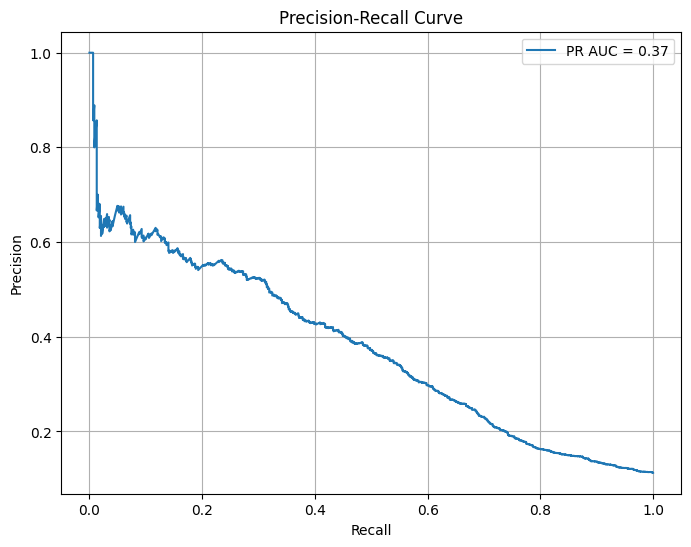

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc
)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

# Assume X and y are preprocessed features and labels
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Compute class weights for imbalance
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

# Define the SVM model
svm_model = SVC(kernel='rbf', class_weight=class_weights_dict, probability=True, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Best model and parameters
best_model = grid_search.best_estimator_
print("\nBest Parameters:")
print(grid_search.best_params_)

# Make predictions using the best model
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]  # Probability for the positive class

# Evaluate the model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute and display ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Compute and plot Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc:.2f}")

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


In [8]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve

#Accuracy is not a good metric on imbalanced data sets, still display it but also calculate
# Precision, Recall, and F1-Score: These metrics give a better understanding of the model’s performance on the minority class.
# ROC-AUC: Measures how well the model distinguishes between the two classes, even in imbalanced scenarios.
# Precision-Recall AUC: This is especially useful when the dataset is highly imbalanced, as it focuses on the performance on the minority class.

#THIS IS AN EXAMPLE OF METRICS, STILL NEEDS MODELS
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"ROC-AUC Score: {roc_auc}")

# Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])



NameError: name 'model' is not defined

As discussed earlier in the notebook, this dataset is an example of an imbalanced data. The target feature, “y” (binary “yes” or “no” feature describing whether or not the customer subscribed a term deposit) is heavily imbalanced. There are nearly seven times more yes answers than no's, which leads to interesting challenges when it comes to machine learning on the data.

First is the issue of actually training a model to effectively distinguish between the two classes. Training most models as you would on balanced data will not work, as machine learning models generally intend to minimize the error rate of classification. In the case of imbalanced data, there are so many more of one class than another that models tend to classify every sample into the majority class. A model using this approach will achieve a relatively high accuracy, but in reality is quite poor at being able to tell the two classes apart. In order to combat this, there are methods that can be utilized to train the models more effectively.

The two methods we have explored in this project are cost-sensitive learning and various sampling approaches.

The cost-sensitive methodology is to assign different weights to each class—i.e. assign a higher weight to the minority class. This leads to a greater punishment, or higher cost, for the incorrect classification of the minority class. The model then attempts to minimize the overall cost while training. Cost-sensitive learning helps the model decrease its tendency to over classify samples into the majority class.

Sampling may also be used to reduce the model’s bias towards one class. This is the approach of adjusting class distributions in the training data. You can either oversample the minority class or undersample the majority class. Oversampling is performed by either duplicating existing samples from the minority class or generating new samples using the patterns found in existing ones. This increases the minority class size and exposes the model to more minority class data. Undersampling, or down-sampling, reduces the size of the majority class by removing some values, also making class distribution more balanced. Oversampling has the potential to lead to overfitting, and undersampling may lead to the loss of valuable information, but both are effective techniques to deal with imbalanced data when used correctly.
